## Show we can use our model on synthesised images

- Generate images of latex equations.
- Feed them to an image classifier with 5 softmax layers
- Note that these match desired inputs from other notebook:
 (pascal_binomial_expansion.ipynb)

This function 'latex2image' is taken from 
https://medium.com/@ealbanez/how-to-easily-convert-latex-to-images-with-python-9062184dc815
By Eduardo Albanez

The rest of the notebook is entirely novel and linked to the paper submission

In [92]:
import matplotlib
import matplotlib.pyplot as plt

# Runtime Configuration Parameters
matplotlib.rcParams["mathtext.fontset"] = "cm"  # Font changed to Computer Modern


def latex2image(
    latex_expression, image_name, image_size_in=(3, 0.5), fontsize=16, dpi=200
):
    """
    A simple function to generate an image from a LaTeX language string.

    Parameters
    ----------
    latex_expression : str
        Equation in LaTeX markup language.
    image_name : str or path-like
        Full path or filename including filetype.
        Accepeted filetypes include: png, pdf, ps, eps and svg.
    image_size_in : tuple of float, optional
        Image size. Tuple which elements, in inches, are: (width_in, vertical_in).
    fontsize : float or str, optional
        Font size, that can be expressed as float or
        {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}.

    Returns
    -------
    fig : object
        Matplotlib figure object from the class: matplotlib.figure.Figure.

    """

    fig = plt.figure(figsize=image_size_in, dpi=dpi)
    text = fig.text(
        x=0.5,
        y=0.5,
        s=latex_expression,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=fontsize,
    )

    plt.savefig(image_name)

    return fig

In [93]:
# test method, creates test.png
latex_expression = '$16 x^{2} + 16 x y + 4 y^{2}$'
image_name = "test.png"
fig = latex2image(latex_expression, image_name, image_size_in=(2, 0.5))

<Figure size 400x100 with 0 Axes>

From this point onward, this is original work.
We intend to generate an example dataset for supervised learning, that we can utilise our Pascal model with

In [94]:
import sympy as sym
import numpy as np
pLevels = 8 
x = sym.Symbol('x')
y = sym.Symbol('y')

In [95]:
import pathlib
pathlib.Path("./data").mkdir(parents=True, exist_ok=True)

In [96]:
def range_excluding(start, stop, exclude=0):
    return [np.r_[start:exclude, exclude+1:stop]]

def make_binomials_exclude_zero(coeff_range=8, power_range=8, x=x, y=y):
    """ 
    Generate deterministic sweep of binomials - avoids duplication with rand and small ranges
    Ignore special case 0 which isn't really a binomial coefficient
    write latex images to file
    """

    x_coeff = np.repeat( np.tile( range_excluding(-coeff_range,coeff_range+1), 2*coeff_range), power_range-1)
    y_coeff = np.repeat( np.repeat( range_excluding(-coeff_range,coeff_range+1), 2*coeff_range), power_range-1)
    binom_power = np.tile( np.tile( np.arange(2,power_range+1), 2*coeff_range), 2*coeff_range )
    eq = []
    fact_eq = []
    for i in range((2*coeff_range)**2 * (power_range-1)):
        factored_e = (x_coeff[i]*x + y_coeff[i]*y) ** binom_power[i]

        fact_eq.append(str(factored_e))
        e = sym.expand(factored_e)
        eq.append( e )
        
        latex_e = sym.latex(factored_e)
        image_name = "./data/" + str(factored_e).replace('**','^').replace('*','') + ".png"
        latex2image('$'+latex_e+'$', image_name, image_size_in=(1.5, 0.4))
        matplotlib.pyplot.close()
    return eq, fact_eq, x_coeff, y_coeff, binom_power


eq, fact_eq, x_coeff, y_coeff, binom_power = make_binomials_exclude_zero(coeff_range=8, power_range=8)


In [97]:
eq[-1]

16777216*x**8 + 134217728*x**7*y + 469762048*x**6*y**2 + 939524096*x**5*y**3 + 1174405120*x**4*y**4 + 939524096*x**3*y**5 + 469762048*x**2*y**6 + 134217728*x*y**7 + 16777216*y**8

In [98]:
fact_eq[-1]

'(8*x + 8*y)**8'

Ok, so we want our labels sorted and then utilised in this keras.utils.dataset, which may be shuffled

In [99]:
fact_eq, x_coeff, y_coeff, binom_power = (list(t) for t in zip(*sorted(zip(fact_eq, x_coeff, y_coeff, binom_power))) )
print(fact_eq[:3])
print(x_coeff[:3])
print(y_coeff[:3])
print(binom_power[:3])

print(len( fact_eq ))
print(len( x_coeff ))
print(len( y_coeff ))

['(-2*x + 2*y)**2', '(-2*x + 2*y)**3', '(-2*x + 2*y)**4']
[-2, -2, -2]
[2, 2, 2]
[2, 3, 4]
1792
1792
1792


In [100]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from tensorflow import data as tf_data


train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data",
    labels=list( zip(x_coeff, y_coeff,binom_power) ),
    color_mode="grayscale",
    batch_size=32,
    image_size=(32, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="both",
    interpolation="bilinear",
)



Found 1792 files belonging to 1792 classes.
Using 1434 files for training.
Using 358 files for validation.


In [ ]:
# illustrate some images and labels

str

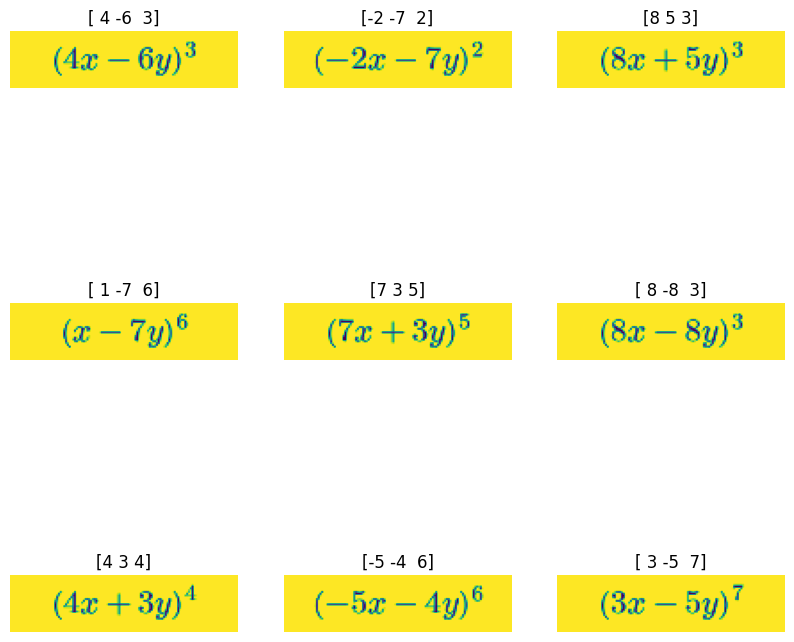

In [102]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(str(np.array( labels[i])).replace("b'","") )
        plt.axis("off")


In [103]:
data_augmentation_layers = [
    layers.RandomZoom(0, .2, seed=123),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=123)
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

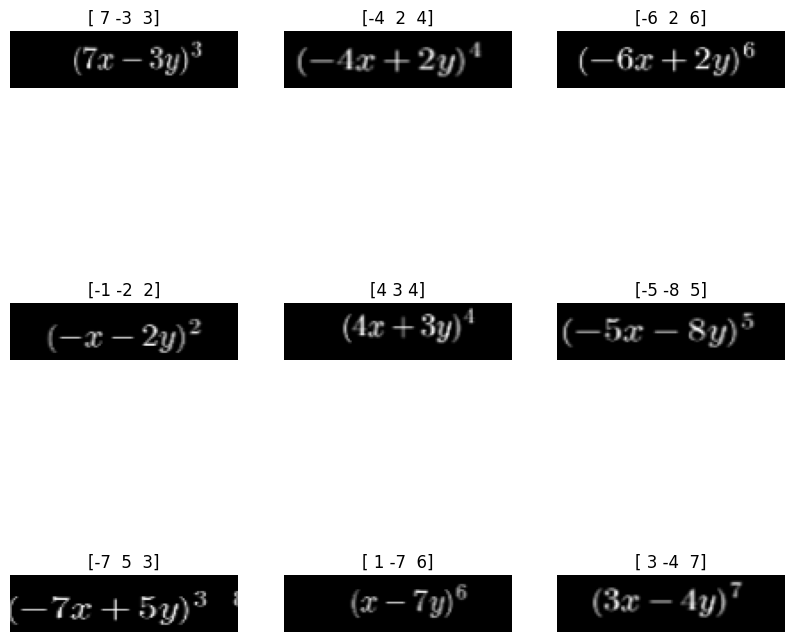

In [104]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[i]).astype("uint8"),cmap='gray_r')
        plt.title(str(np.array( labels[i])).replace("b'","") )
        plt.axis("off")

Ok, so here we want to strip + and - from our x and y coefficients.
We also subtract 1, since integers used in classification will be 0-7 not 1-8.
We subtract 2 from power since 0-6 will be used rather than 2-8

In [105]:
def prep_tensors_from_ds(ds):
    """ pass a dataset and strip out relevant targets """
    XTrain = []
    YTrain_A = []
    YTrain_B = []
    YTrain_C = []
    plus_X = []
    plus_Y = []

    for images, labels in ds:
        for idx,im in enumerate(images):
            XTrain.append( np.array(im).astype("uint8") )
            x = labels[idx][0]
            if x<0:
                x = x * -1
                plus_X.append(0)
            else:
                plus_X.append(1)
            y = labels[idx][1]
            if y<0:
                y = y * -1
                plus_Y.append(0)
            else:
                plus_Y.append(1)
            YTrain_A.append( x-1 )
            YTrain_B.append( y-1 )
            YTrain_C.append( labels[idx][2]-2 )

    XTrain = np.array(XTrain)
    YTrain_A = np.array( YTrain_A )
    YTrain_B = np.array( YTrain_B )
    YTrain_C = np.array( YTrain_C )
    plus_X = np.array( plus_X )
    plus_Y = np.array( plus_Y )
    return XTrain, YTrain_A, YTrain_B, YTrain_C, plus_X, plus_Y

In [106]:
XTrain, YTrain_A, YTrain_B, YTrain_C, plus_XTrain, plus_YTrain = prep_tensors_from_ds(train_ds)

XVal, YVal_A, YVal_B, YVal_C, plus_XVal, plus_YVal = prep_tensors_from_ds(val_ds)

In [107]:
def convblock(x, kernels):
    x = layers.Conv2D(kernels, (3, 3), activation=None, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x, negative_slope=0.0, max_value=None, threshold=0.0)
    x = layers.MaxPool2D(pool_size=(2, 4))(x)
    return x

input_layer = layers.Input(shape=(32,128,1),name="latex_in")
x = data_augmentation(input_layer)
x = layers.Rescaling(1./255)(x)
x = convblock(x, 32)
x = convblock(x, 64)
x = convblock(x, 128)
x = layers.Flatten()(x)

x_coeff_out = layers.Dense(8)(x)  
y_coeff_out = layers.Dense(8)(x) 
power_out = layers.Dense(len(np.unique(binom_power)))(x)
plus_X_out = layers.Dense(2)(x)
plus_Y_out = layers.Dense(2)(x)

x_coeff_out = layers.Softmax(name="x_out")(x_coeff_out)
y_coeff_out = layers.Softmax(name="y_out")(y_coeff_out)
power_out = layers.Softmax(name="power_out")(power_out)
plus_X_out = layers.Softmax(name="xplus_out")(plus_X_out)
plus_Y_out = layers.Softmax(name="yplus_out")(plus_Y_out)



In [108]:
latex_model = keras.Model(inputs=input_layer, outputs=[x_coeff_out, y_coeff_out, power_out, plus_X_out, plus_Y_out])


latex_model.compile(loss={'x_out': keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    'y_out': keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    'power_out': keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    'xplus_out': keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    'yplus_out': keras.losses.SparseCategoricalCrossentropy(from_logits=False)},
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics={'x_out': tf.metrics.SparseCategoricalAccuracy(name='x_acc'), 
                    'y_out': tf.metrics.SparseCategoricalAccuracy(name='y_acc'),
                    'power_out': tf.metrics.SparseCategoricalAccuracy(name='power_acc'),
                    'xplus_out': tf.metrics.SparseCategoricalAccuracy(name='xplus_acc'),
                    'yplus_out': tf.metrics.SparseCategoricalAccuracy(name='yplus_acc'),})


latex_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latex_in            │ (None, 32, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_4       │ (None, 32, 128,   │          0 │ latex_in[0][0]    │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 32, 128,   │          0 │ random_zoom_4[0]… │
│ (RandomTranslation) │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 32, 128,   │          0 │ random_translati… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 128,   │        320 │ rescaling_4[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128,   │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 32, 128,   │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 32,    │          0 │ re_lu_12[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 32,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 16, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 64)  │          0 │ re_lu_13[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 4, 2, 128) │          0 │ re_lu_14[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1024)      │          0 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 8)         │      8,200 │ flatten_4[0][0] 

 Total params: 121,243 (473.61 KB)

 Trainable params: 120,795 (471.86 KB)

 Non-trainable params: 448 (1.75 KB)

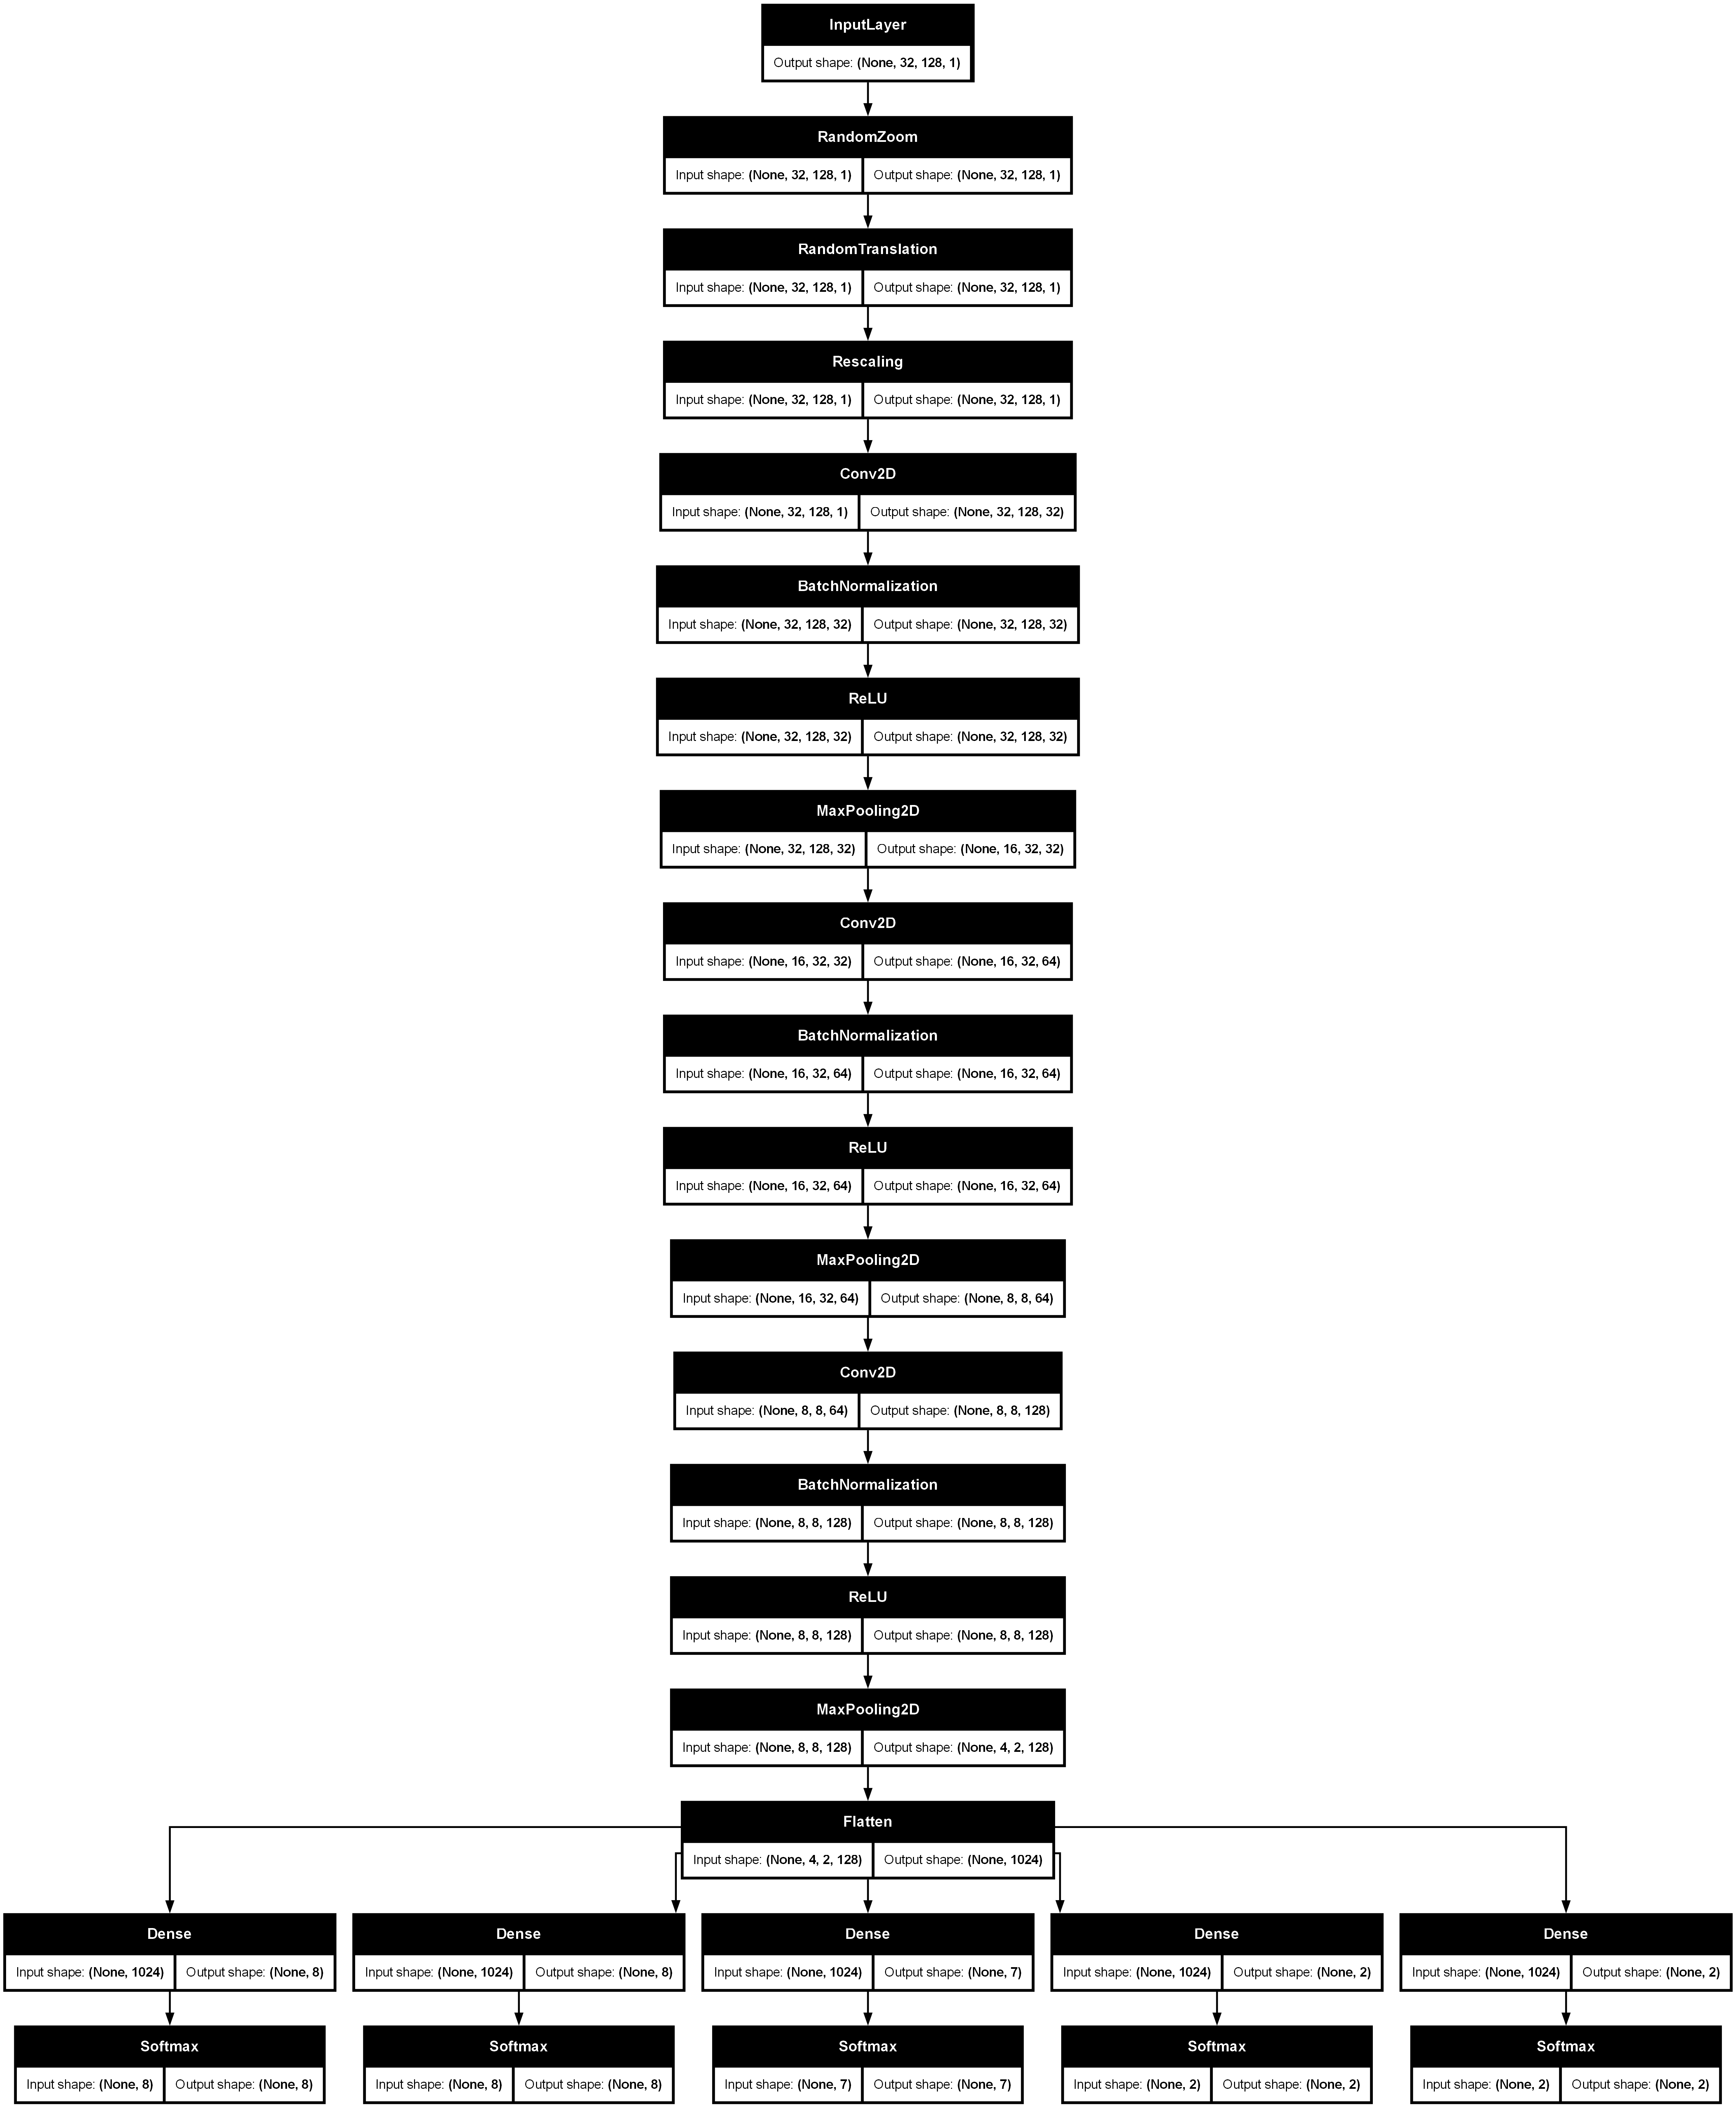

In [109]:
keras.utils.plot_model(latex_model,"pascal_full_DAG.png", show_shapes=True)

In [110]:
"""
here, we use in-memory arrays for training derived from train_ds
this conserves the test/val split but allows us to use 5 softmax outputs
"""
#history = latex_model.fit(train_ds, epochs=10, batch_size=32)
history = latex_model.fit(XTrain,
                          [YTrain_A,YTrain_B,YTrain_C,plus_XTrain,plus_YTrain], 
                          epochs=15, 
                          batch_size=32,
                          validation_data=(XVal,[YVal_A,YVal_B,YVal_C,plus_XVal,plus_YVal]),)



Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 9.1751 - power_out_loss: 2.2752 - power_out_power_acc: 0.1480 - x_out_loss: 2.5618 - x_out_x_acc: 0.1737 - xplus_out_loss: 0.6539 - xplus_out_xplus_acc: 0.7836 - y_out_loss: 2.6250 - y_out_y_acc: 0.1693 - yplus_out_loss: 1.0590 - yplus_out_yplus_acc: 0.6090 - val_loss: 7.6077 - val_power_out_loss: 1.9452 - val_power_out_power_acc: 0.1425 - val_x_out_loss: 2.0931 - val_x_out_x_acc: 0.1257 - val_xplus_out_loss: 0.7122 - val_xplus_out_xplus_acc: 0.4916 - val_y_out_loss: 2.1219 - val_y_out_y_acc: 0.1006 - val_yplus_out_loss: 0.7040 - val_yplus_out_yplus_acc: 0.5000
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.9341 - power_out_loss: 1.9352 - power_out_power_acc: 0.2185 - x_out_loss: 1.7484 - x_out_x_acc: 0.3489 - xplus_out_loss: 0.1266 - xplus_out_xplus_acc: 0.9738 - y_out_loss: 1.7592 - y_out_y_acc: 0.3759 - yplus_out_loss: 0.3646 - yplus_out_yplus_acc: 0.8487 - val_loss: 8.3705 - val_power_out_loss: 1.9689 - val_po

In [111]:
# evaluate
latex_model.evaluate(XVal,[YVal_A,YVal_B,YVal_C,plus_XVal,plus_YVal])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1248 - power_out_loss: 0.0149 - power_out_power_acc: 1.0000 - x_out_loss: 0.0172 - x_out_x_acc: 1.0000 - xplus_out_loss: 0.0045 - xplus_out_xplus_acc: 1.0000 - y_out_loss: 0.0231 - y_out_y_acc: 1.0000 - yplus_out_loss: 0.0651 - yplus_out_yplus_acc: 0.9909


[0.12612438201904297,
 0.018181266263127327,
 0.024809524416923523,
 0.013629510067403316,
 0.004777278285473585,
 0.0647306814789772,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9888268113136292]

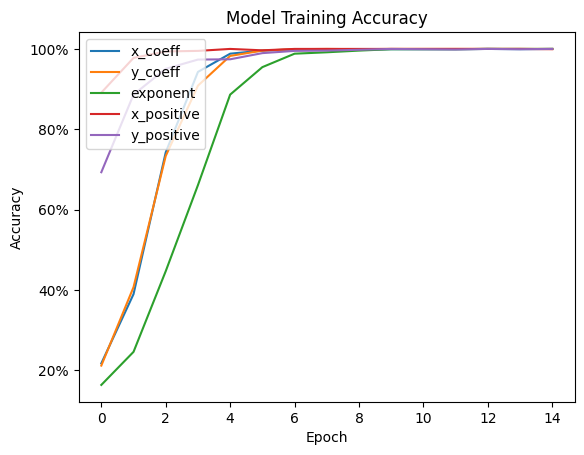

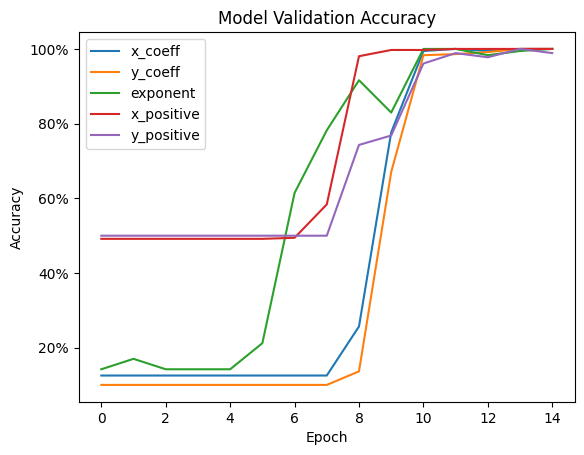

In [115]:
# plots from training
from matplotlib import pyplot as plt
import warnings
# ignore warning about yticks
warnings.filterwarnings('ignore')

def plot_results(title="Training", prefix=''):
    plt.plot(history.history[prefix+'x_out_x_acc'])
    plt.plot(history.history[prefix+'y_out_y_acc'])
    plt.plot(history.history[prefix+'power_out_power_acc'])
    plt.plot(history.history[prefix+'xplus_out_xplus_acc'])
    plt.plot(history.history[prefix+'yplus_out_yplus_acc'])
    plt.title(f'Model {title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['x_coeff', 'y_coeff','exponent','x_positive','y_positive'], loc='upper left')
    plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])

    plt.show()

plot_results(title="Training", prefix='')
plot_results(title="Validation", prefix='val_')

In [113]:
history.history.keys()

dict_keys(['loss', 'power_out_loss', 'power_out_power_acc', 'x_out_loss', 'x_out_x_acc', 'xplus_out_loss', 'xplus_out_xplus_acc', 'y_out_loss', 'y_out_y_acc', 'yplus_out_loss', 'yplus_out_yplus_acc', 'val_loss', 'val_power_out_loss', 'val_power_out_power_acc', 'val_x_out_loss', 'val_x_out_x_acc', 'val_xplus_out_loss', 'val_xplus_out_xplus_acc', 'val_y_out_loss', 'val_y_out_y_acc', 'val_yplus_out_loss', 'val_yplus_out_yplus_acc'])